In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

## Accuracy
from sklearn.metrics import accuracy_score
## Precision
from sklearn.metrics import precision_score
## Recall
from sklearn.metrics import recall_score

## Load data 
rootins_og = pd.read_csv("Root_Insurance_data.csv")
root_insurance = rootins_og.copy()
root_insurance.head()

## Change Column Names 
root_ins = root_insurance.rename({'Currently Insured':'Currently_Insured','Number of Vehicles':'NumVehicles',
                                  'Number of Drivers':'NumDrivers','Marital Status':'MaritalStat','rank':'Rank'},axis='columns')
root_ins.head()

,Currently_Insured,NumVehicles,NumDrivers,MaritalStat,bid,Rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0


In [2]:
## Random Forest
## Features: NumVehicles, NumDrivers, MS, Rank, Click, Currently_insured
## y: policies_sold

## df1 = features
df1 = root_ins[['NumVehicles','NumDrivers','Rank','click']] ## Numerical
##df1 = root_ins[['NumVehicles','NumDrivers','Rank']] ## Numerical, predicting click
df1[['No_insur','Yes_insur']] = pd.get_dummies(root_ins.Currently_Insured)[['N','Y']] ## Including Currently_Insured
df1['Married'] = pd.get_dummies(root_ins.MaritalStat)['M']
df1['click'] = df1['click'] * 1



C:\Users\vrish\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-2-13105fb547f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Married'] = pd.get_dummies(root_ins.MaritalStat)['M']
<ipython-input-2-13105fb547f2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [3]:
## Convert to numpy
X = df1.to_numpy()
y = root_ins.policies_sold.to_numpy()

## Training/Testing Set

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)

## Run Random Forest, default parameters (100 trees, no max depth)
rf = RandomForestClassifier()


## Feature Selection
rf.fit(X_train,y_train)
pred = rf.predict(X_test)
rf.feature_importances_

names = []
scores = []
for name, score in zip(df1.columns,rf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

print(score_df.sort_values('importance_score',ascending=False))

print('Accuracy = ',accuracy_score(y_test,pred))
print('Precision = ',precision_score(y_test,pred))
print('Recall = ',recall_score(y_test,pred))

## Plot a single decision tree 
##plt.figure(figsize=(20,20))
##_ = tree.plot_tree(rf.estimators_[1], feature_names=df1.columns, filled=True)

       feature  importance_score
3        click            0.7357
2         Rank            0.1199
0  NumVehicles            0.0520
6      Married            0.0263
1   NumDrivers            0.0262
5    Yes_insur            0.0229
4     No_insur            0.0169
Accuracy =  0.918
Precision =  0.4748603351955307
Recall =  0.4336734693877551


C:\Users\vrish\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vrish\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vrish\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vrish\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

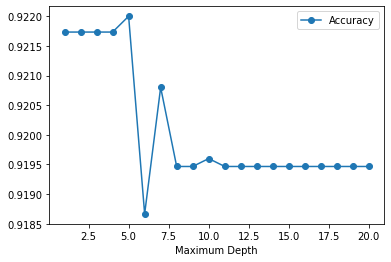

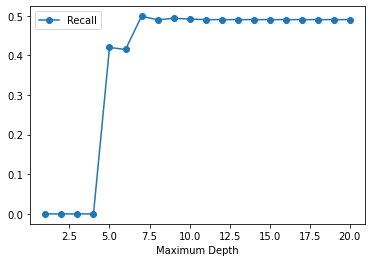

In [4]:
## Optimization of Random Forest, y = policies sold 

## 5-fold cross validation to determine max_depth for rank vs customer info

numSplits = 5 ## CV splits
depth = 20 ## maximum_depth testined

kfold = StratifiedKFold(n_splits=numSplits,shuffle = True,random_state=440)

rf_acc = np.empty((numSplits,depth))
rf_prec = np.empty((numSplits,depth))
rf_recall = np.empty((numSplits,depth))


i = 0
for train_ind, test_ind in kfold.split(X_train,y_train):
    X_train_train, X_train_test = X_train[train_ind], X_train[test_ind]
    y_train_train, y_train_test = y_train[train_ind], y_train[test_ind]
##    print(y_train_test)
    for j in range(1,depth+1):
        ## Model
        rf = RandomForestClassifier(n_estimators =100, max_depth = j, random_state = 614)
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train, y_train_train)
        ypred = rf_clone.predict(X_train_test)
        
        ## Metrics 

        rf_acc[i,j-1] = accuracy_score(y_train_test, ypred)
        rf_prec[i,j-1] = precision_score(y_train_test, ypred)
        rf_recall[i,j-1] = recall_score(y_train_test, ypred)
    
    i = i+1
    
plt.figure()
plt.plot(np.arange(1,depth+1), np.mean(rf_acc,axis = 0),'-o',label = 'Accuracy')
plt.xlabel('Maximum Depth')
plt.legend()

plt.figure()
plt.plot(np.arange(1,depth+1), np.mean(rf_prec,axis = 0),'-o',label = 'Recall')
plt.xlabel('Maximum Depth')
plt.legend()

In [5]:
## Based on the recall measurement, maximum depth should be 10
max_depth = 10

## Testing data
rf = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, random_state = 614)
rf.fit(X_train,y_train)
ypred_act = rf.predict(X_test)

acc = accuracy_score(y_test,ypred_act)
recall = recall_score(y_test,ypred_act)
prec = precision_score(y_test,ypred_act)

print('Accuracy = ',acc)
print()
print('Recall = ',recall)
print()
print('Precision = ',prec)
print()

names = []
scores = []
for name, score in zip(df1.columns,rf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

print(score_df.sort_values('importance_score',ascending=False))

##plt.figure(figsize=(20,20))
##_ = tree.plot_tree(rf.estimators_[10], feature_names=df1.columns, filled=True)

Accuracy =  0.9176

Recall =  0.413265306122449

Precision =  0.47093023255813954

       feature  importance_score
3        click            0.7358
2         Rank            0.1198
0  NumVehicles            0.0502
6      Married            0.0274
1   NumDrivers            0.0261
5    Yes_insur            0.0231
4     No_insur            0.0176


In [ ]:
## Predicting Rank based on customer Info using Random Forest 
## Convert to numpy
df2 = df1[['NumVehicles','NumDrivers','No_insur','Yes_insur','Married']].copy()
X2 = df2.to_numpy()
y2 = root_ins['Rank'].to_numpy()

## Training/Testing Set

X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y2)

## Run Random Forest, default parameters
rf2 = RandomForestClassifier()

## Feature Selection
rf2.fit(X_train2,y_train2)
rf2.feature_importances_

names = []
scores = []
for name, score in zip(df2.columns,rf2.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

print(score_df.sort_values('importance_score',ascending=False))

## Plot a single decision tree 
##plt.figure(figsize=(20,20))
##_ = tree.plot_tree(rf.estimators_[1], feature_names=df1.columns, filled=True)


In [ ]:
## 5-fold cross validation to determine max_depth for rank vs customer info

numSplits = 5 ## CV splits
depth = 20 ## maximum_depth testined

kfold = StratifiedKFold(n_splits=numSplits,shuffle = True,random_state=440)

rf_acc2 = np.empty((numSplits,depth))
##rf2_prec2 = np.empty((depth,numSplits))
##rf2_recall2 = np.empty((depth,numSplits))


kfold = StratifiedKFold(n_splits=numSplits,shuffle = True,random_state=440)

i = 0
for train_ind, test_ind in kfold.split(X_train2,y_train2):
    X_train_train, X_train_test = X_train2[train_ind], X_train2[test_ind]
    y_train_train, y_train_test = y_train2[train_ind], y_train2[test_ind]
##    print(y_train_test)
    for j in range(1,depth+1):
        ## Model
        rf2 = RandomForestClassifier(n_estimators =100, max_depth = j, random_state = 614)
        rf_clone2 = clone(rf2)
        rf_clone2.fit(X_train_train, y_train_train)
        ypred2 = rf_clone2.predict(X_train_test)
        
        ## Metrics 

        rf_acc2[i,j-1] = accuracy_score(y_train_test, ypred)
##        rf_prec2[i,j-1] = precision_score(y_train_test, ypred)
##        rf_recall2[i,j-1] = recall_score(y_train_test, ypred)
    
    i = i+1
    
plt.figure()
plt.plot(np.arange(1,depth+1), np.mean(rf_acc,axis = 0),'-o',label = 'Accuracy')
plt.xlabel('Maximum Depth')
plt.legend()
        

In [ ]:
## Based on the accuracy measurement, maximum depth should be 6, predicting rank based on customer data
## max_depth value influences the top feature 
max_depth = 5

## Testing data
rf2 = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, random_state = 614)
rf2.fit(X_train2,y_train2)
ypred_act2 = rf2.predict(X_test2)

acc = accuracy_score(y_test2,ypred_act2)

print('Accuracy = ',acc)

names = []
scores = []
for name, score in zip(df2.columns,rf2.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

print(score_df.sort_values('importance_score',ascending=False))

In [ ]:
## SVM?
from sklearn.svm import LinearSVC




In [ ]:
## Predicting Rank based on customer Info using Linear Regression
 
## Simple linear regression, x = NumVehicles, y = Rank
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 

## Assumptions
## Linearity
rho = np.corrcoef(root_ins.NumVehicles,root_ins.Rank)
print('The correlation coefficient is: ',rho[0,1])


## Independence
linR = LinearRegression()
linR.fit(X_train2[:,0].reshape(-1,1),y_train2)
ypred = linR.predict(X_test2[:,0].reshape(-1,1))

# Residuals vs. NumVehicles 
plt.figure()
plt.plot(X_test2[:,0],y_test2-ypred,'o')
plt.xlabel('NumVehicles')
plt.ylabel('Residuals')

# Homoscadiscity 
plt.figure()
sm.qqplot(y_test-ypred,line='s')
plt.xlabel('Normal Quantiles')
plt.ylabel('Residual Quantiles')

plt.figure()
plt.hist(y_test-ypred)
plt.show()

## Fails the Assumptions, linear regression is not applicable 